In [4]:
import random
import time
import pandas as pd
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

from functools import partial

In [86]:
df = pd.read_csv("../../data/bandits/bandits_rewards.csv")

In [91]:
df.arm = df.arm - 1 #make it zero indexed

In [92]:
data = list(zip(df.arm, df.reward))

In [93]:
data[:10]

[(3, 2.81),
 (0, 5.31),
 (3, 7.53),
 (4, 3.37),
 (3, 4.35),
 (4, 8.25),
 (0, 5.92),
 (2, 5.8),
 (2, 2.66),
 (0, 5.33)]

### Arms and synthetic reward generator

In [6]:
class GaussianArm():
    """
    An arm with a gaussian distribution (bounded)
    """
    def __init__(self, mean, stdev, minv, maxv):
        """
        @param mean: mean of the distribution
        @param stdev: standard deviation of the distribution
        @param minv: minimum possible value
        @param maxv: maximum possible value
        """
        self.mean = mean
        self.stdev = stdev
        self.minv = minv
        self.maxv = maxv

    def pull(self):
        """
        Pull the arm and get a reward
        @return the reward
        """
        reward = min(self.maxv, max(self.minv, round(normal(loc=self.mean, scale=self.stdev),2)))
        return reward
    
    def pull_list(self, T):
        """
        Pull the arm T times
        @return the list of rewards
        """
        rewards = normal(loc=self.mean, scale=self.stdev, size=T)
        rewards = [min(self.maxv, max(self.minv, round(r,2))) for r in rewards]
        return rewards

class SyntheticDataGenerator:
    """
    A utility class to generate synthetic data from arms
    """
    
    def __init__(self, arms_params):
        """
        @param params: list of tuples (mean, stdev, minv, maxv) representing parmeters
                       of the arms' distributions of rewards
        """
        self.K = len(arms_params)
        self.arms_params = []
    
    def generate(self, T):
        """
        Generate T samples
        @return a list of (arm_id, reward) pairs
        """
        sequence = []
        for arm_idx in range(0,self.K):
            arm = GaussianArm(*arms_params[arm_idx])
            data = arm.pull_list(T//K)
            data = [ (arm_idx, min(maxv, max(minv, round(d,2)))) for d in data]
            sequence += data
        random.shuffle(sequence)
        return sequence

### Multi-Armed Bandits strategies

In [151]:
class EpsilonGreedy:
    """
    Epsilon greedy MAB
    """
    def __init__(self, epsilon, K):
        """
        @param epsilon : the epsilon-greedy exploration parameter
        @param K: number of arms
        """
        if epsilon < 0 or epsilon > 1:
            raise Exception ('Epsilon should be in [0,1]')
        self.epsilon = epsilon
        self.K = K
        self.avg_rewards = np.zeros(self.K)  # average reward for each arm
        self.tot_rewards = np.zeros(self.K)  # total reward for each arm
        self.times_pulled = np.zeros(self.K)  # number of times each arm was pulled
        
    def get_tot_reward(self):
        """
        @return the total reward accumulated
        """
        return sum(self.tot_rewards)
    
    def get_number_pulls(self):
        """
        @return the total number of times an arm has been pulled
        """
        return sum(self.times_pulled)
    
    def __str__(self):
        s = f'=== MAB state ===\n'
        s += f'Epsilon Greedy: epsilon={self.epsilon}, arms={self.K}\n'
        s += f'Trained with {self.get_number_pulls()} actions; Total reward = {self.get_tot_reward()}\n'
        s += f'Avg. reward = {self.avg_rewards}\n'
        s += f'# pulls = {self.times_pulled}\n'
        s += '================='
        return s
        
    def select_arm(self, arm=None, m:int=None):
        """
        Select the best arm according to the strategy
        @return arm: the index of the selected arm
        @return explore: binary value encoding whether the MAB decided to explore
        """
        if arm is not None:
            return arm, 0
        else:
            if m:
                return (np.random.choice(range(0,self.K)), 1)
            else:
                p = np.random.rand()
                if p > self.epsilon:
                    best_arm_idx = np.argmax(self.avg_rewards)
                    return (best_arm_idx, 0)
                else:
                    return (np.random.choice(range(0,self.K)), 1)

    def update(self, arm, reward):
        """
        Update the model parameters
        @param arm: arm 
        @param reward : binary value
        """
        self.times_pulled[arm] += 1
        self.tot_rewards[arm] += reward
        self.avg_rewards[arm] = self.tot_rewards[arm] / self.times_pulled[arm]
        
    def reset(self):
        """
        Reset the state of MAB
        """
        self.avg_rewards = np.zeros(self.K)
        self.tot_rewards = np.zeros(self.K)
        self.times_pulled = np.zeros(self.K)
        self.pull_history = []
    
    def run_simulation(self, arms, T, specific_arm=None, verbose=False, m:int=None):
        """
        Runs a simulation on the given arms for T timesteps
        @param arms: List of Arms objects
        @param T: length of the simulation
        """
        simulation_cum_rewards = []
        simulation_tot_rewards = 0
        pull_history = []
        if len(arms) != K:
            raise Exception(f'number of arms shuould be K={self.K}')
        elif specific_arm is not None:
            self.select_arm = partial(self.select_arm, arm=specific_arm)
        for t in range(0, T):
            if m is not None:
                if t <= m:
                    mab_arm, has_explored = self.select_arm(m=m)
                else:
                    mab_arm, has_explored = self.select_arm(m=None)
            else:
                mab_arm, has_explored = self.select_arm(m=None)
            arm, has_explored = self.select_arm()
            reward = arms[arm].pull()
            simulation_tot_rewards += reward
            simulation_cum_rewards.append(simulation_tot_rewards)
            pull_history.append(arm)
            self.update(arm, reward)
            if verbose:
                print(f'ROUND {t} ---')
                print(f'arm={arm}, has_explored={has_explored}, reward={reward}')
                print(f'avg_rewards = {self.avg_rewards}')
        return (simulation_cum_rewards, pull_history)
        
    def run_replay(self, data, specific_arm=None, verbose=False, evaluation_n:int=None, m:int=None):
        """
        Runs a Replay offline evaluation with the given data
        @param data: a list of (arm,reward) pairs
        @param verbose: for a verbose representation of the replay
        """
        replay_num_matches = 0
        replay_tot_rewards = 0
        replay_cum_rewards = []
        pull_history = []
        
        if specific_arm is not None:
            self.select_arm = partial(self.select_arm, arm=specific_arm)
        
        for i, action in enumerate(data):
            if m is not None:
                if i <= m:
                    mab_arm, has_explored = self.select_arm(m=m)
                else:
                    mab_arm, has_explored = self.select_arm(m=None)
            else:
                mab_arm, has_explored = self.select_arm(m=None)
            actual_arm, reward = action
            if mab_arm == actual_arm: #change the state of the MAB only if there is a match
                if verbose:
                    print(f'ROUND {replay_num_matches} ({i}) ---')
                    print(f'arm={actual_arm}, mab_arm={mab_arm}, match={mab_arm == actual_arm}, has_explored={has_explored}, reward={reward}')
                    print(f'avg_rewards = {self.avg_rewards}')
                replay_num_matches += 1
                replay_tot_rewards += reward
                replay_cum_rewards.append(replay_tot_rewards)
                pull_history.append(mab_arm)
                mab.update(mab_arm, reward)
            if replay_num_matches == evaluation_n:
                break
        return (replay_cum_rewards, pull_history)
    
    
def visualize_simulation(cum_rewards, pull_history, savefile=None):
    """
    Utility function to draw a visual representation of the simulation
    @param cum_rewards: list of cumulative rewards in time
    @param pull_history: list of arm indices pulled over time
    """
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    ax1, ax2=axs
    ax1.plot(range(0,len(cum_rewards)), cum_rewards)
    ax1.set_ylabel('Cumulative reward', fontsize=18)
    ax1.set_xlabel('Rounds', fontsize=18)
    ax2.scatter(range(0,len(pull_history)), pull_history, s=4, alpha=0.8)
    ax2.set_ylabel('Arms', fontsize=18)
    ax2.set_xlabel('Rounds', fontsize=18)
    ax1.tick_params(labelsize=18)
    ax2.tick_params(labelsize=18)
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=400)

# Simulation
    Simulation of the baseline model and five naive models. 
    
    Note that the baseline models are also of the class epsilon_greedy, but I have modified its select_arm() method s.t.
    if a specific arm is to be selected at all times, it will only return that arm and 0 from its select_arm() call. 
    
## Settings

In [152]:
#create example arms
minv=1 #minimum value of reward
maxv=10 #maximum value of reward
arms = [GaussianArm(3, 1, minv, maxv), 
        GaussianArm(3.5, 1, minv, maxv), 
        GaussianArm(4.5, 1, minv, maxv), 
        GaussianArm(1.8, 1, minv, maxv),
        GaussianArm(4.5, 0.8, minv, maxv)] 

#instantiate MAB
K = len(arms)
alpha = 0.1
#run simulation on given arms
T = 5000

##  Baseline 1
    This is an epsilon-greedy model.

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 22013.900000000023
Avg. reward = [2.9432     3.53577982 4.47919643 1.86446429 4.52446279]
# pulls = [ 125.  109.  112.  112. 4542.]


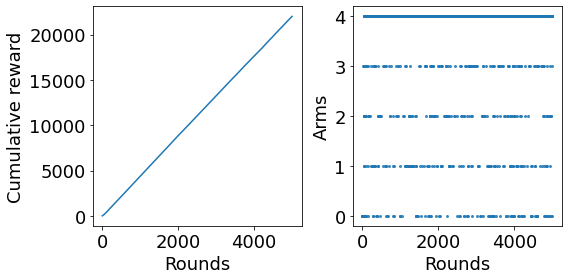

In [159]:
mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=None, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

## Baseline 2
    Epsilon first: This model pulls random arms the first m rounds. Then it switches to epsilon-greedy like the one above. 
    m was chosen to 100 arbitrarily. 

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 21900.330000000038
Avg. reward = [3.1153     3.50179245 4.426      1.74271845 4.48639071]
# pulls = [ 100.  106.  125.  103. 4566.]


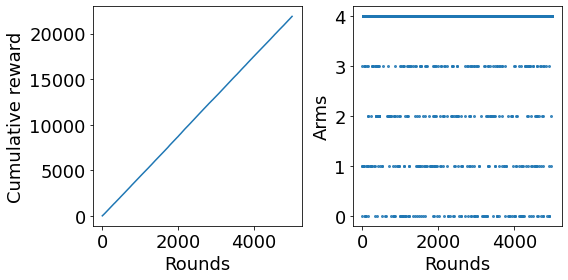

In [160]:
mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=None, verbose=False, m=100)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

## Naive Models

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 15074.470000000001
Avg. reward = [3.014894 0.       0.       0.       0.      ]
# pulls = [5000.    0.    0.    0.    0.]


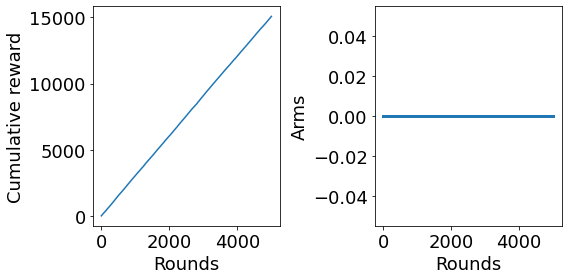

In [161]:
# Always 0

mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=0, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 17644.36999999999
Avg. reward = [0.       3.528874 0.       0.       0.      ]
# pulls = [   0. 5000.    0.    0.    0.]


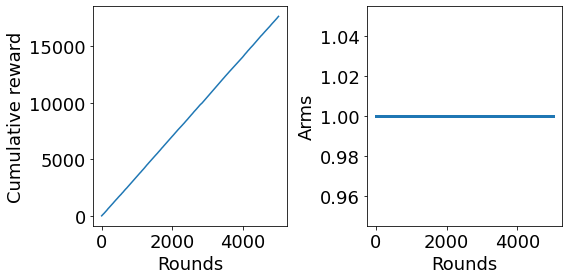

In [162]:
# Always 1

mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=1, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 22503.109999999946
Avg. reward = [0.       0.       4.500622 0.       0.      ]
# pulls = [   0.    0. 5000.    0.    0.]


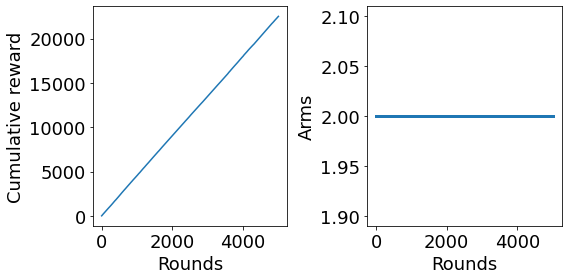

In [163]:
# Always 2

mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=2, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 9595.820000000022
Avg. reward = [0.       0.       0.       1.919164 0.      ]
# pulls = [   0.    0.    0. 5000.    0.]


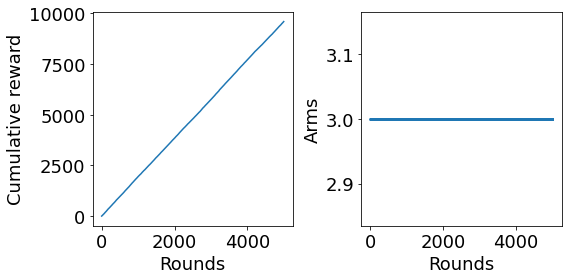

In [164]:
# Always 3

mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=3, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 22495.990000000005
Avg. reward = [0.       0.       0.       0.       4.499198]
# pulls = [   0.    0.    0.    0. 5000.]


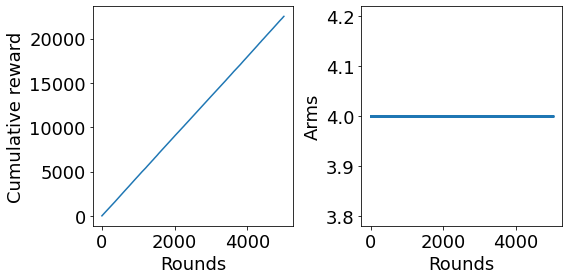

In [165]:
# Always 4

mab = EpsilonGreedy(alpha, K)
cum_rewards, pull_history = mab.run_simulation(arms, T, specific_arm=4, verbose=False)
print(mab)
visualize_simulation(cum_rewards, pull_history, 'fig.png')

    From above, the epsilon greedy, the epsilon first and the model always picking arm=2 seems best, as their cumulative reward is higher. However, we need to do an offline evaluation to be sure. 

# Offline Evaluation
    We now run a replay evaluation of the baseline and the five naive approaches. We use the data from the bandits_reward.csv file here to compare the choices of the mabs to the actual observation from the data. 

## Settings

In [166]:
#create example arms
minv=1 #minimum value of reward
maxv=10 #maximum value of reward
arms = [GaussianArm(3, 1, minv, maxv), 
        GaussianArm(3.5, 1, minv, maxv), 
        GaussianArm(4.5, 1, minv, maxv), 
        GaussianArm(1.8, 1, minv, maxv),
        GaussianArm(4.5, 0.8, minv, maxv)]

K = len(arms)
alpha = 0.1

## Bandit 1

In [167]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25449.68
Avg. reward = [5.14413399 0.         4.79166667 5.08364951 5.08251724]
# pulls = [ 612.    0.   18. 4080.  290.]


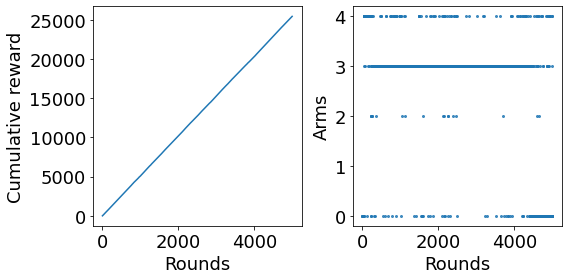

In [168]:
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=None, verbose=False, evaluation_n=5000, m=None)
print(mab)
visualize_simulation(cum_rewards, pull_history)

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25253.750000000022
Avg. reward = [4.9276555  0.         4.78444444 5.05689805 5.04947674]
# pulls = [ 209.    0.    9. 4610.  172.]


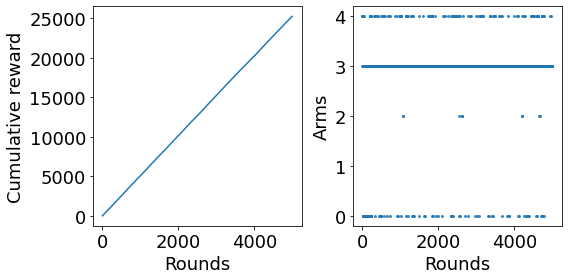

In [169]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=None, verbose=False, evaluation_n=5000, m=100)
print(mab)
visualize_simulation(cum_rewards, pull_history)

## Naive Approaches

    Always picking arm=0

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25583.389999999945
Avg. reward = [5.116678 0.       0.       0.       0.      ]
# pulls = [5000.    0.    0.    0.    0.]


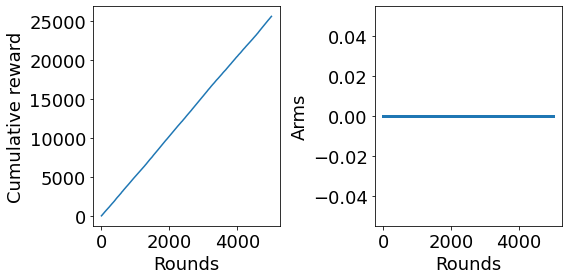

In [150]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=0, verbose=False, evaluation_n=5000)
print(mab)
visualize_simulation(cum_rewards, pull_history)

    Always picking arm=1

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25330.660000000033
Avg. reward = [0.       5.066132 0.       0.       0.      ]
# pulls = [   0. 5000.    0.    0.    0.]


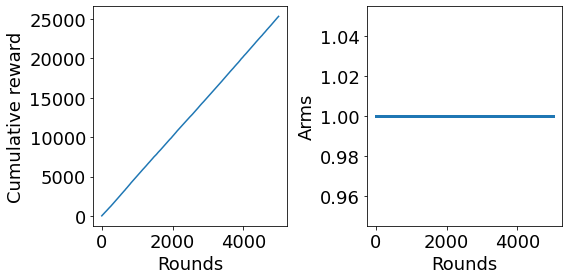

In [130]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=1, verbose=False, evaluation_n=5000)
print(mab)
visualize_simulation(cum_rewards, pull_history)

    Always picking arm=2

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25205.810000000027
Avg. reward = [0.       0.       5.041162 0.       0.      ]
# pulls = [   0.    0. 5000.    0.    0.]


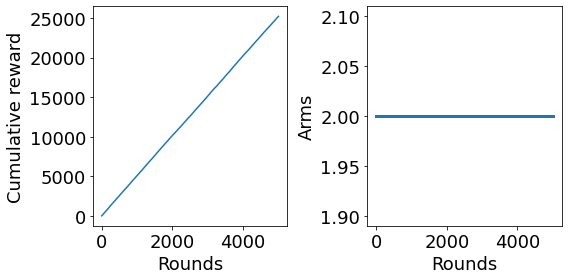

In [131]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=2, verbose=False, evaluation_n=5000)
print(mab)
visualize_simulation(cum_rewards, pull_history)

        Always picking arm=3

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25311.43000000002
Avg. reward = [0.       0.       0.       5.062286 0.      ]
# pulls = [   0.    0.    0. 5000.    0.]


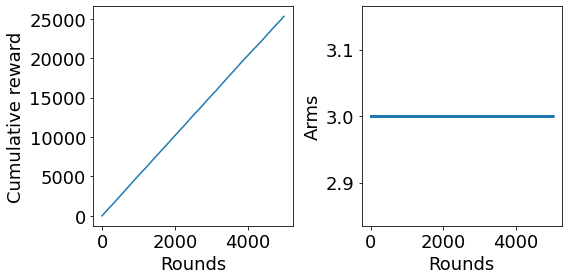

In [132]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=3, verbose=False, evaluation_n=5000)
print(mab)
visualize_simulation(cum_rewards, pull_history)

    Always picking arm=4

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 5000.0 actions; Total reward = 25314.699999999928
Avg. reward = [0.      0.      0.      0.      5.06294]
# pulls = [   0.    0.    0.    0. 5000.]


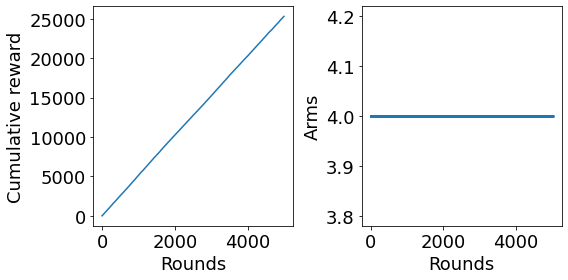

In [133]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=4, verbose=False, evaluation_n=5000)
print(mab)
visualize_simulation(cum_rewards, pull_history)

    We can observe that these models are all equally good/bad. Their cumulative rewards are all in the area of ~25000. 
    This is unexpected, but it might have something to do with the epsilon-greedy model and epsilon first model are exploring a lot. I ran a comparison on the entire data set (1 000 000 pulls): The the epsilon-first model outperformed the others. Example below with the greedy-epsilon, epsilon-first and model=2.

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 139941.0 actions; Total reward = 708192.7599999986
Avg. reward = [5.05731231 5.08223396 5.05636585 5.04507185 5.05829753]
# pulls = [88459. 22534.  2050.  8977. 17921.]


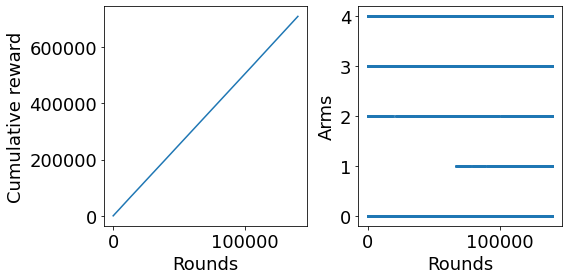

In [135]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=None, verbose=False, evaluation_n=None)
print(mab)
visualize_simulation(cum_rewards, pull_history)

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 393679.0 actions; Total reward = 1999398.4899999667
Avg. reward = [5.05620868 5.03092857 5.02472615 5.0805409  5.04974874]
# pulls = [ 15095.    840.   1132. 369090.   7522.]


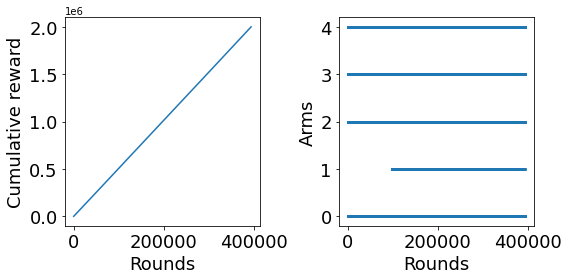

In [170]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=None, verbose=False, evaluation_n=None, m=100)
print(mab)
visualize_simulation(cum_rewards, pull_history)

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 55343.0 actions; Total reward = 279566.4899999986
Avg. reward = [0.         0.         5.05152395 0.         0.        ]
# pulls = [    0.     0. 55343.     0.     0.]


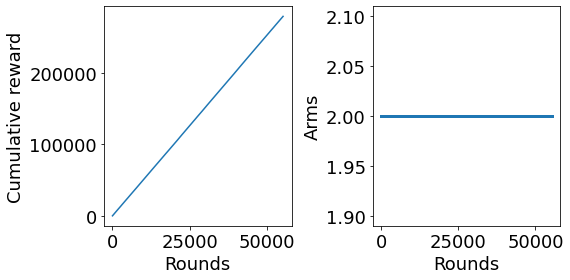

In [137]:
#instantiate MAB
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, specific_arm=2, verbose=False, evaluation_n=None)
print(mab)
visualize_simulation(cum_rewards, pull_history)

    In conclusion, the greedy-epsilon and epsilon-first approach works better than the naive approaches, however we need to test a lot more than 5000 pulls to be sure. Also, the epsilon-first seems to be better than the greedy-epsilon on this data set when doing a hundred random pulls at the start. 